## Laboratorio 5

Ignacio Méndez Alvarez (22613) y Diego Soto Flores (22737)

Enlace al GitHub: https://github.com/Disotoo/DS-Lab-5.git

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score

#### Stopwords

In [2]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nanum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

#### Carga del archivo

In [79]:
data = pd.read_csv("train.csv")
data2 = pd.read_csv("test.csv")
train = data[["text", "target"]]
test = data[["text", "target"]]
train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


Al momento de cargar los datos se eliminaron las columnas de id, keyword y location. Se realizó de esta forma ya que la columna de id no aporta nada para el set de train ya que se conoce el target. La columna de keyword no aporta nada ya que hay muchas filas en donde este dato esta vacio y solo puede complicar el analisis. La columna de location de la misma forma tiene muchos valores vacios y el lugar no aporta inforación valiosa para la clasificación de desastre o no. 

#### Limpieza y preprocesamiento de datos

In [59]:
df_911 = train[train["text"].str.contains(r"\b911\b", regex=True, na=False)]

# Imprimir los textos encontrados
print("Textos donde aparece 911:")
for t in df_911["text"]:
    print("-", t)

Textos donde aparece 911:
- @_jeesss_ @Ethereal_7 Hello 911 yeah we have someone drowning here send a medic http://t.co/7GiglwdMhy
- Came across this fire video not mine..enjoy..#fire #firemen #firetruck #emergency #rescue #911 #summertime #sirensÛ_ http://t.co/hcYAJsAcfJ
- County 911 Overload Prompts Use of Emergency Plan During July 4 Celebrations http://t.co/HXTUPrA5bc http://t.co/DqxKJibbKy
- Kirsten Gillibrand http://t.co/amEA3LaMDj    Extend Health Care To 911 First RESPONDERS !


Analizando la existencia de tweets con el número **"911"** se tomó la decisión de eliminarlos al igual que el resto de números. Esto se debe a que la cantidad de apariciones es baja y su uso no influye tanto en la elección de target.

In [85]:
def limpiar(text):
    text = text.lower()                                 # minúsculas
    text = re.sub(r"[‘’´`]", "'", text)
    text = re.sub(r"[“”]", '"', text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # quitar URLs
    text = re.sub(r"\s*&amp\s*", " ", text)  # quitar '&amp' y limpiar espacios extra
    text = re.sub(r"@\w+", "", text)                    # quitar usuarios
    text = re.sub(r"<.*?>", " ", text)                  # quitar tags HTML
    text = re.sub(r"\[.*?\]", "", text)                 # quitar palabras dentro de []
    text = re.sub(r"[0-9]+[a-zA-Z]*", "", text)         # quitar palabras que combinen numeros y letras
    text = re.sub(r"[\U00010000-\U0010ffff]", "", text)  
    text = re.sub(r"[^a-zA-Z\s]", "", text)             # quitar símbolos/números
    text = re.sub(r"\s+", " ", text).strip()            # quitar espacios extra
    text = re.sub(r"\bu\b", "", text)                   # quitar 'u' sueltas
    text = re.sub(r"\bvia\b", "", text)                   # quitar 'via' sueltas
    text = re.sub(r"\bnew\b", "", text)                   # quitar 'new' sueltas
    text = re.sub(r"\bim\b", "", text)                   # quitar 'im' sueltas
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

train["clean_text"] = train["text"].apply(limpiar)
train

C:\Users\nanum\AppData\Local\Temp\ipykernel_19540\872461059.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["clean_text"] = train["text"].apply(limpiar)


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fires california even northern pa...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigating ebike collided car little...


Para la función limpiar se tomo el texto de los tweets y se normalizaron las minúsculas, se limpiaron los espacios extras, se quitaron los URLs, los tags HTML, las palabras dentro de [ ], las palabras que combinan números y letras, los símbolos/números y algunas palabras que consideramos importante eliminar como las "u" sueltas, "via" o "&amp". 

#### Análisis de texto

In [ ]:
# Texto combinado por clasificación
desastres = " ".join(train[train.target == 1]["clean_text"])
no_desastres = " ".join(train[train.target == 0]["clean_text"])

train

,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fires california even northern pa...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigating ebike collided car little...


#### Frecuencia de palabras

In [87]:
# Wordcloud de palabras sobre desastre
wordcloud_dis = WordCloud(width=600, height=400, background_color="white").generate(desastres)

# Diccionario de palabras y frecuencias relativas
frecuencias_des = wordcloud_dis.words_
print(type(frecuencias_des))
print(list(frecuencias_des.items())[:10])


<class 'dict'>
[('fire', 1.0), ('news', 0.6335877862595419), ('us', 0.549618320610687), ('storm', 0.4961832061068702), ('flood', 0.48091603053435117), ('one', 0.48091603053435117), ('death', 0.4732824427480916), ('suicide bomber', 0.4580152671755725), ('car', 0.44274809160305345), ('people', 0.4351145038167939)]


In [88]:
# Wordcloud de palabras sobre no desastres
wordcloud_non = WordCloud(width=600, height=400, background_color="white", colormap="Reds").generate(no_desastres)

# Diccionario de palabras y frecuencias relativas
frecuencias_non = wordcloud_non.words_
print(type(frecuencias_non))
print(list(frecuencias_non.items())[:10])


<class 'dict'>
[('one', 1.0), ('time', 0.7983193277310925), ('day', 0.7478991596638656), ('dont', 0.7310924369747899), ('people', 0.7310924369747899), ('see', 0.7058823529411765), ('got', 0.7058823529411765), ('love', 0.680672268907563), ('back', 0.680672268907563), ('cant', 0.6638655462184874)]


#### ¿Qué palabras cree que le servirán para hacer un mejor modelo de clasificación?
Viendo los wordclouds de los desastres y no desastres, se puede ver que algunas de las palabras que servirán para un mejor modelo son:
- Para desastres: fire, storm, wildfire, death, flood
- Para no desastres: hope, day, time, make, everyone, love

#### ¿Vale la pena explorar bigramas o trigramas para analizar contexto?
Si, los bigramas y trigramas traen más perspectiva a las palabras clave de los tweets. Tanto los bigramas como los trigramas pueden ayudar a clasificar mejorar, por lo que es importante analizar los patrones de palabras encontrados. 

#### Análisis exploratorio de los datos

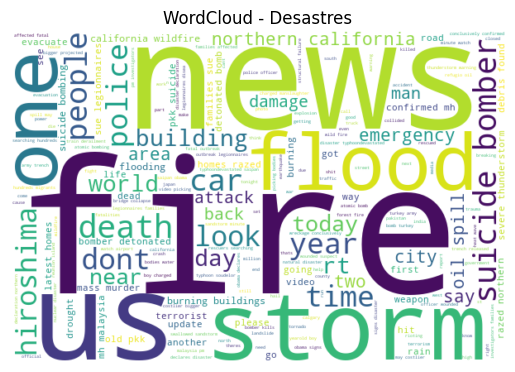

In [89]:
plt.imshow(wordcloud_dis, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Desastres")
plt.show()

En tweets de desastres, la palabra que más se repite es "fire".

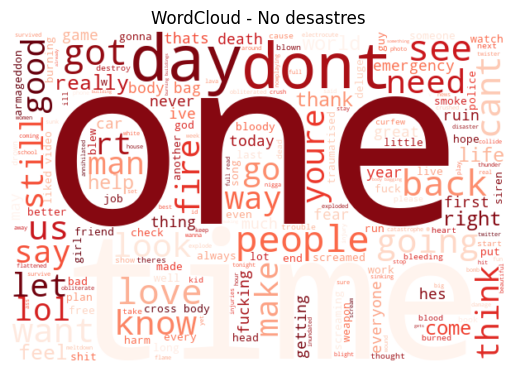

In [90]:
plt.imshow(wordcloud_non, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - No desastres")
plt.show()

En tweets de no desastres, la palabra que más se repite es "one".

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,3))  # bigramas y trigramas
X = vectorizer.fit_transform(train["clean_text"])
y = train["target"]

print("Tamaño del vocabulario:", len(vectorizer.get_feature_names_out()))
print("Algunas palabras/bigramas:", list(vectorizer.get_feature_names_out())[:15])

Tamaño del vocabulario: 83489
Algunas palabras/bigramas: ['aa ayyo', 'aa ayyo dei', 'aa batteries', 'aa batteries swear', 'aaaa ok', 'aaaa ok lemme', 'aaaaaaallll even', 'aaaaaaallll even season', 'aaaaaand theres', 'aaaaaand theres thunder', 'aan den', 'aan den rijn', 'aannnnd reddit', 'aannnnd reddit quarantine', 'aar ambulancewe']


In [92]:
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

,aa ayyo,aa ayyo dei,aa batteries,aa batteries swear,aaaa ok,aaaa ok lemme,aaaaaaallll even,aaaaaaallll even season,aaaaaand theres,aaaaaand theres thunder,...,zouma absolutely,zouma absolutely flattened,zouma flattened,zouma flattened cfc,zouma flattened guy,zss vs,zss vs sws,zumiez location,zurich swiss,zurich swiss premiere
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Histogramas

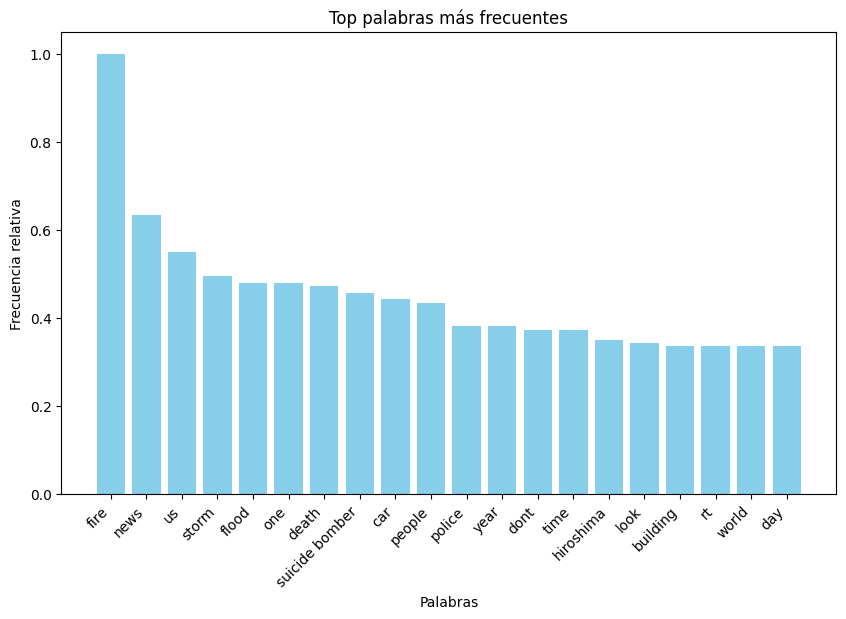

In [93]:
# Histograma de palabras en desastres
N = 20  
palabras = list(frecuencias_des.keys())[:N]
valores = list(frecuencias_des.values())[:N]

plt.figure(figsize=(10,6))
plt.bar(palabras, valores, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top palabras más frecuentes")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia relativa")
plt.show()

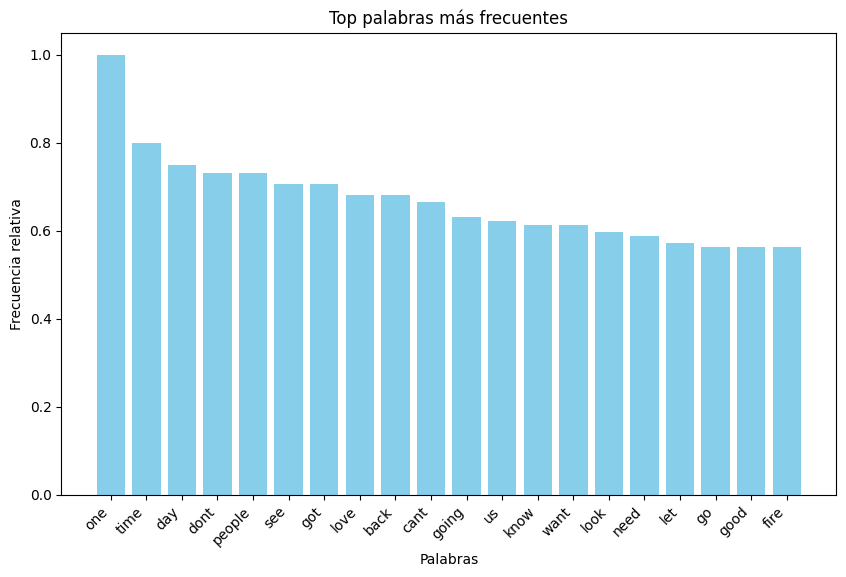

In [94]:
# Histograma de palabras en no desastres
N = 20  
palabras = list(frecuencias_non.keys())[:N]
valores = list(frecuencias_non.values())[:N]

plt.figure(figsize=(10,6))
plt.bar(palabras, valores, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top palabras más frecuentes")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia relativa")
plt.show()

#### Discutir sobre las palabras que tienen presencia en todas las categorías.
Hay algunas palabras que se repiten tanto en desastre como en no desastres. Algunas de ellas son fire, one, don't, day, time, people. Es normal que estas palabras estén en las dos categorías, porque pueden usarse en ambos tipos de comentarios, pues son palabras normales. La única un poco controversial es "fire", pero en inglés mucha gente tiende a usar esa palabra para describir cosas que les gustan, no necesariamente un fuego como tal. 

#### Uso de bigramas y trigramas

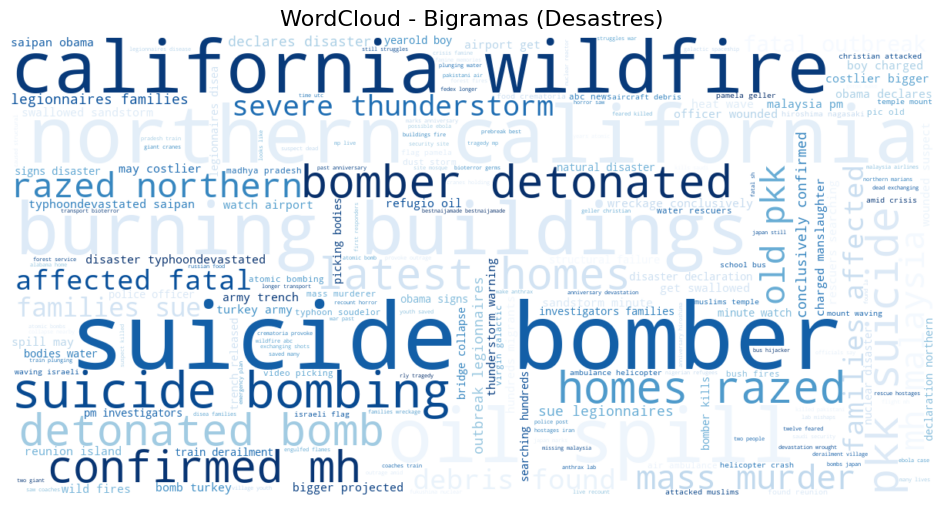

In [95]:
# Desastres en bigramas
vectorizer = CountVectorizer(ngram_range=(2,2))
biX = vectorizer.fit_transform(pd.Series(desastres).astype(str))
features = vectorizer.get_feature_names_out()
freq = np.asarray(biX.sum(axis=0)).ravel()
bigrams_dis = dict(zip([f.replace(" ", " ") for f in features], freq))

wc = WordCloud(width=1200, height=600, background_color="white",
               colormap="Blues", collocations=False, max_words=200)
wc.generate_from_frequencies(bigrams_dis)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Bigramas (Desastres)", fontsize=16)
plt.show()

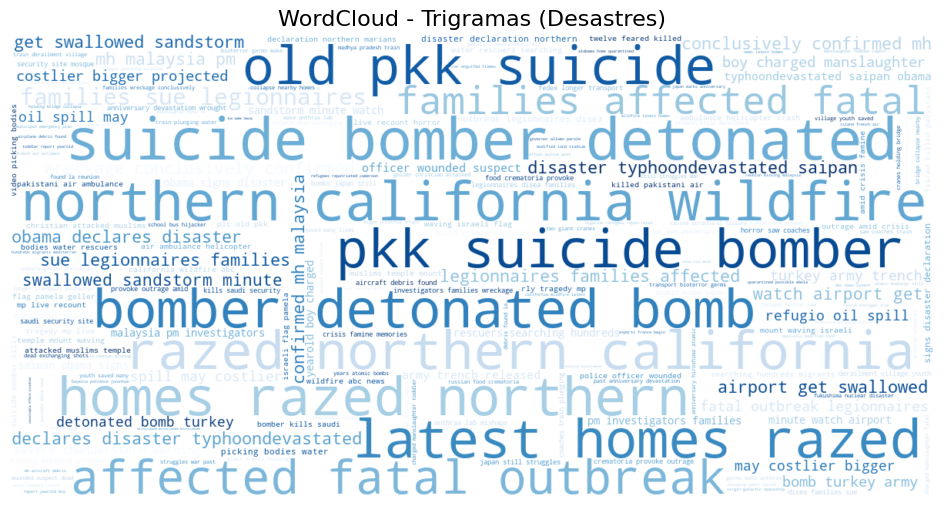

In [96]:
# Desastres en trigramas
vectorizer = CountVectorizer(ngram_range=(3,3))
triX = vectorizer.fit_transform(pd.Series(desastres).astype(str))
features = vectorizer.get_feature_names_out()
freq = np.asarray(triX.sum(axis=0)).ravel()
trigrams_dis = dict(zip([f.replace(" ", " ") for f in features], freq))

wc = WordCloud(width=1200, height=600, background_color="white",
               colormap="Blues", collocations=False, max_words=200)
wc.generate_from_frequencies(trigrams_dis)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Trigramas (Desastres)", fontsize=16)
plt.show()

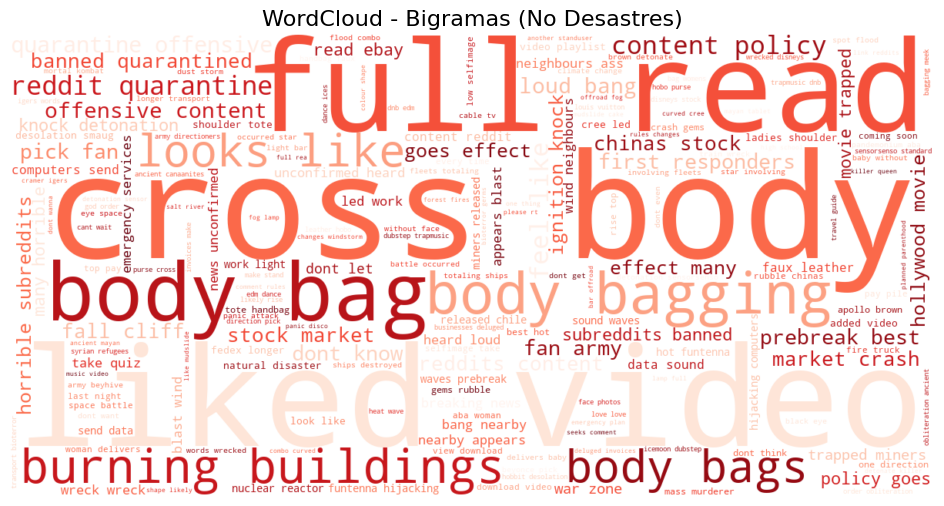

In [97]:
# No desastres en bigramas
vectorizer = CountVectorizer(ngram_range=(2,2))
biX = vectorizer.fit_transform(pd.Series(no_desastres).astype(str))
features = vectorizer.get_feature_names_out()
freq = np.asarray(biX.sum(axis=0)).ravel()
bigrams_non = dict(zip([f.replace(" ", " ") for f in features], freq))

wc = WordCloud(width=1200, height=600, background_color="white",
               colormap="Reds", collocations=False, max_words=200)
wc.generate_from_frequencies(bigrams_non)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Bigramas (No Desastres)", fontsize=16)
plt.show()

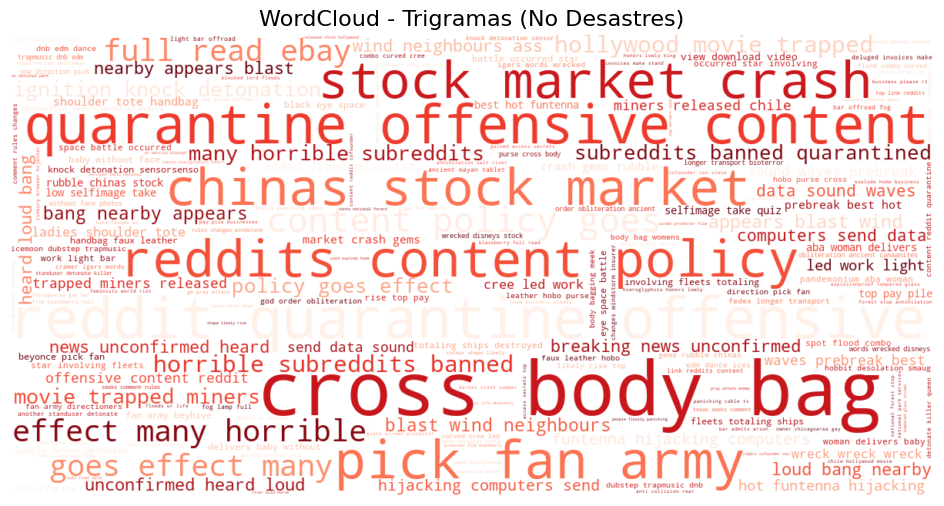

In [98]:

# No desastres en trigramas
vectorizer = CountVectorizer(ngram_range=(3,3))
triX = vectorizer.fit_transform(pd.Series(no_desastres).astype(str))
features = vectorizer.get_feature_names_out()
freq = np.asarray(triX.sum(axis=0)).ravel()
trigrams_non = dict(zip([f.replace(" ", " ") for f in features], freq))

wc = WordCloud(width=1200, height=600, background_color="white",
               colormap="Reds", collocations=False, max_words=200)
wc.generate_from_frequencies(trigrams_non)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Trigramas (No Desastres)", fontsize=16)
plt.show()


#### Modelo preliminar

In [121]:
vectorizer = CountVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(train["clean_text"])
y = train["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(solver="liblinear")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\nReporte de Clasificación:\n")
print(classification_report(y_test, y_pred))



Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1318
           1       0.83      0.69      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.81      0.80      2284



In [122]:
cm = confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)

print('Matriz de confusión:\n',cm)
print('Accuracy: ',accuracy)

Matriz de confusión:
 [[1179  139]
 [ 301  665]]
Accuracy:  0.8073555166374781


#### Función de predicción

In [123]:
def predict_sentiment(text):
    clean = limpiar(text)
    vec = vectorizer.transform([clean])
    pred = model.predict(vec)[0]
    return "Desastre 🤯" if pred == 1 else "No desastre 😌"

# Ejemplos
print(predict_sentiment("The storm keeps getting worse"))
print(predict_sentiment("The weather is nice today"))

Desastre 🤯
No desastre 😌
